In [7]:
import torch
import torch.nn as nn

In [8]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built using an MLP."""

  def __init__(self, embed_dim=256, input_dim=6, hidden_dim=512):
    """Initialize a time-dependent score-based network.

    Args:
      embed_dim: The dimensionality of Gaussian random feature embeddings.
      input_dim: The dimensionality of the input (latent space).
      hidden_dim: The dimensionality of the hidden layers.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim),
        nn.SiLU(),
        nn.Linear(embed_dim, embed_dim)
    )
    
    self.lin1 = nn.Linear(input_dim, hidden_dim)
    self.dense1 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin2 = nn.Linear(hidden_dim, hidden_dim)
    self.dense2 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin3 = nn.Linear(hidden_dim, hidden_dim)
    self.dense3 = nn.Linear(embed_dim, hidden_dim)
    
    self.lin4 = nn.Linear(hidden_dim, input_dim)
    
    # The swish activation function
    self.act = nn.SiLU()
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))
    
    h = self.lin1(x)
    h += self.dense1(embed)
    h = self.act(h)
    
    h = self.lin2(h)
    h += self.dense2(embed)
    h = self.act(h)
    
    h = self.lin3(h)
    h += self.dense3(embed)
    h = self.act(h) 
    
    h = self.lin4(h)

    return h

In [9]:
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [10]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, args.latent_dim)
        self.fc22 = nn.Linear(400, args.latent_dim)
        self.fc3 = nn.Linear(args.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class VAE_DDPM(nn.Module):

    def __init__(self, vae_network: nn.Module, diff_network: nn.Module, T:int=100, beta_1:float=1e-4, beta_T:float=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model with VAE latent space.

        Parameters
        ----------
        vae_network: nn.Module
            nerual network for VAE encoder/decoder
        diff_network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(VAE_DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        self._diff_network = diff_network
        self.diff_network = lambda x, t: self._diff_network(x, t.squeeze()/T)

        self.vae_network = vae_network

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0:torch.Tensor, t:int, epsilon:torch.Tensor) -> torch.Tensor:
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt:torch.Tensor, t:int, epsilon:torch.Tensor) -> torch.Tensor:
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.diff_network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. (nsamples, VAE latent dim)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        xt_vae = self.vae_network.decode(xt)

        return xt_vae

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Encode input image into VAE latent space
        x0_vae, _ = self.vae_network.encode(x0.view(-1, 784))

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        # Sample noise
        epsilon = torch.randn_like(x0_vae)
        # Forward diffusion to obtain xt
        xt = self.forward_diffusion(x0_vae, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.diff_network(xt, t))
    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()

Training:   0%|          | 0/11750 [00:00<?, ?it/s]

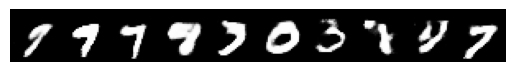

Training:   2%|▏         | 235/11750 [00:05<04:21, 44.09it/s, epoch=2/50, loss=⠀      0.9463, lr=9.77E-04]

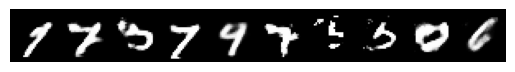

Training:   4%|▍         | 470/11750 [00:11<04:10, 45.02it/s, epoch=3/50, loss=⠀      0.9952, lr=9.54E-04]

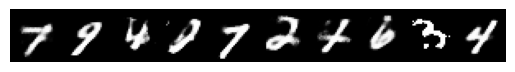

Training:   6%|▌         | 705/11750 [00:17<04:04, 45.23it/s, epoch=4/50, loss=⠀      0.8234, lr=9.32E-04]

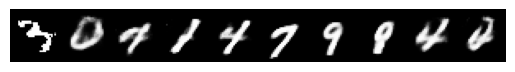

Training:   8%|▊         | 940/11750 [00:22<03:53, 46.32it/s, epoch=5/50, loss=⠀      0.8860, lr=9.10E-04]

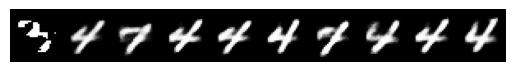

Training:  10%|█         | 1175/11750 [00:28<04:03, 43.52it/s, epoch=6/50, loss=⠀      0.5479, lr=8.89E-04]

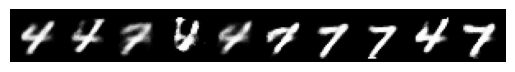

Training:  12%|█▏        | 1410/11750 [00:33<03:46, 45.57it/s, epoch=7/50, loss=⠀      0.5884, lr=8.68E-04]

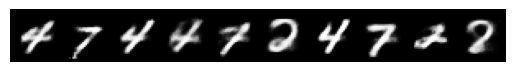

Training:  14%|█▍        | 1645/11750 [00:39<03:41, 45.65it/s, epoch=8/50, loss=⠀      0.5739, lr=8.48E-04]

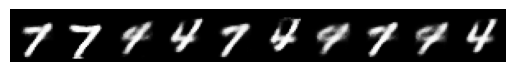

Training:  16%|█▌        | 1880/11750 [00:45<03:56, 41.79it/s, epoch=9/50, loss=⠀      0.4825, lr=8.29E-04]

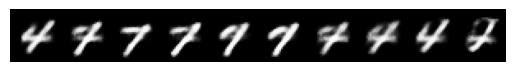

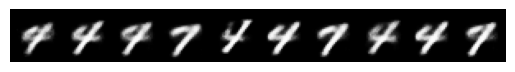

Training:  20%|██        | 2350/11750 [00:56<03:27, 45.20it/s, epoch=11/50, loss=⠀      0.4220, lr=7.90E-04]

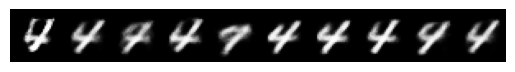

Training:  22%|██▏       | 2585/11750 [01:01<03:25, 44.65it/s, epoch=12/50, loss=⠀      0.3683, lr=7.72E-04]

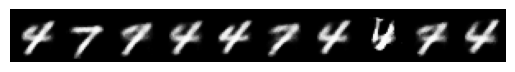

Training:  24%|██▍       | 2820/11750 [01:07<03:20, 44.50it/s, epoch=13/50, loss=⠀      0.4025, lr=7.54E-04]

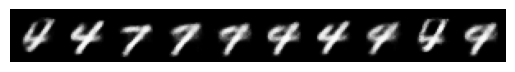

Training:  26%|██▌       | 3055/11750 [01:13<03:36, 40.11it/s, epoch=14/50, loss=⠀      0.2945, lr=7.37E-04]

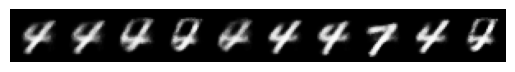

Training:  28%|██▊       | 3290/11750 [01:18<03:03, 46.10it/s, epoch=15/50, loss=⠀      0.3190, lr=7.20E-04]

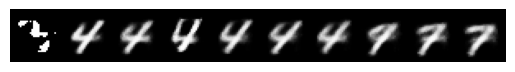

Training:  30%|███       | 3525/11750 [01:24<03:01, 45.25it/s, epoch=16/50, loss=⠀      0.2797, lr=7.03E-04]

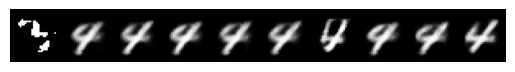

Training:  32%|███▏      | 3760/11750 [01:29<02:53, 45.92it/s, epoch=17/50, loss=⠀      0.3465, lr=6.87E-04]

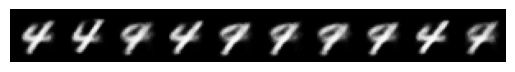

Training:  34%|███▍      | 3995/11750 [01:35<02:54, 44.49it/s, epoch=18/50, loss=⠀      0.3117, lr=6.71E-04]

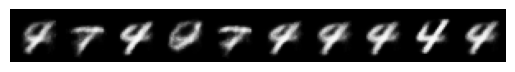

Training:  36%|███▌      | 4230/11750 [01:40<02:51, 43.94it/s, epoch=19/50, loss=⠀      0.2162, lr=6.55E-04]

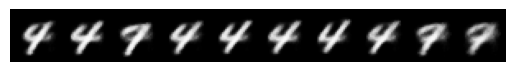

Training:  38%|███▊      | 4465/11750 [01:46<02:53, 41.99it/s, epoch=20/50, loss=⠀      0.1899, lr=6.40E-04]

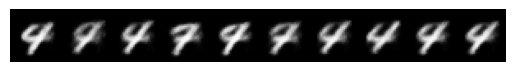

Training:  40%|████      | 4700/11750 [01:52<02:44, 42.95it/s, epoch=21/50, loss=⠀      0.3025, lr=6.25E-04]

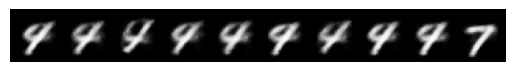

Training:  42%|████▏     | 4935/11750 [01:57<02:40, 42.47it/s, epoch=22/50, loss=⠀      0.1849, lr=6.10E-04]

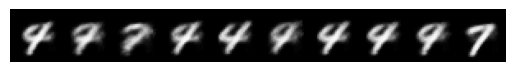

Training:  44%|████▍     | 5170/11750 [02:03<02:49, 38.84it/s, epoch=23/50, loss=⠀      0.1789, lr=5.96E-04]

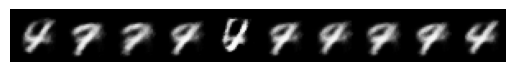

Training:  46%|████▌     | 5405/11750 [02:09<02:40, 39.64it/s, epoch=24/50, loss=⠀      0.1864, lr=5.82E-04]

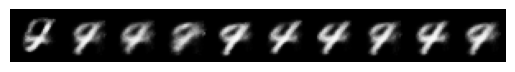

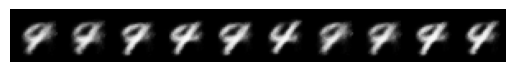

Training:  50%|█████     | 5875/11750 [02:20<02:16, 43.00it/s, epoch=26/50, loss=⠀      0.1828, lr=5.56E-04]

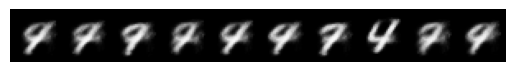

Training:  52%|█████▏    | 6110/11750 [02:26<02:13, 42.14it/s, epoch=27/50, loss=⠀      0.1450, lr=5.43E-04]

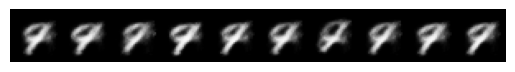

Training:  54%|█████▍    | 6345/11750 [02:31<02:02, 44.05it/s, epoch=28/50, loss=⠀      0.2518, lr=5.30E-04]

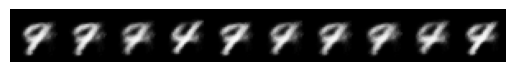

Training:  56%|█████▌    | 6580/11750 [02:37<01:59, 43.29it/s, epoch=29/50, loss=⠀      0.2195, lr=5.18E-04]

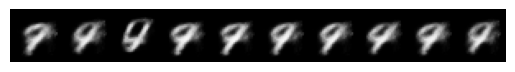

Training:  58%|█████▊    | 6815/11750 [02:43<02:01, 40.52it/s, epoch=30/50, loss=⠀      0.1425, lr=5.06E-04]

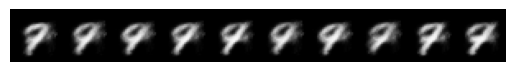

Training:  60%|██████    | 7050/11750 [02:48<01:48, 43.50it/s, epoch=31/50, loss=⠀      0.1398, lr=4.94E-04]

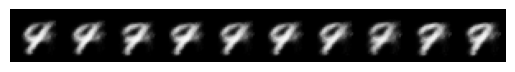

Training:  62%|██████▏   | 7285/11750 [02:54<01:42, 43.69it/s, epoch=32/50, loss=⠀      0.1845, lr=4.83E-04]

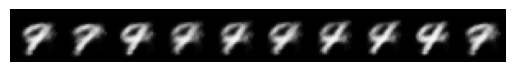

Training:  64%|██████▍   | 7520/11750 [02:59<01:35, 44.30it/s, epoch=33/50, loss=⠀      0.1487, lr=4.71E-04]

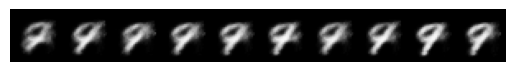

Training:  66%|██████▌   | 7755/11750 [03:05<01:32, 43.01it/s, epoch=34/50, loss=⠀      0.2085, lr=4.60E-04]

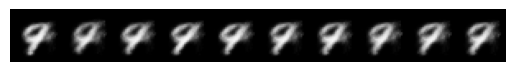

Training:  68%|██████▊   | 7990/11750 [03:11<01:28, 42.26it/s, epoch=35/50, loss=⠀      0.1282, lr=4.50E-04]

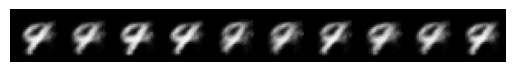

Training:  70%|███████   | 8225/11750 [03:17<01:21, 43.35it/s, epoch=36/50, loss=⠀      0.1776, lr=4.39E-04]

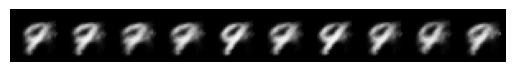

Training:  72%|███████▏  | 8460/11750 [03:23<01:23, 39.50it/s, epoch=37/50, loss=⠀      0.1973, lr=4.29E-04]

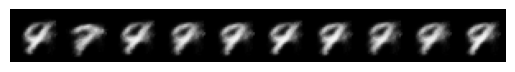

Training:  74%|███████▍  | 8696/11750 [03:29<01:15, 40.54it/s, epoch=38/50, loss=⠀      0.1824, lr=4.19E-04]

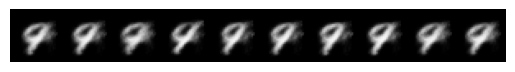

Training:  76%|███████▌  | 8931/11750 [03:36<01:04, 43.81it/s, epoch=39/50, loss=⠀      0.1771, lr=4.09E-04]

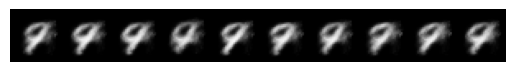

Training:  78%|███████▊  | 9165/11750 [03:41<00:59, 43.49it/s, epoch=40/50, loss=⠀      0.1399, lr=4.00E-04]

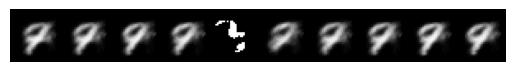

Training:  80%|████████  | 9400/11750 [03:47<00:54, 43.27it/s, epoch=41/50, loss=⠀      0.1799, lr=3.91E-04]

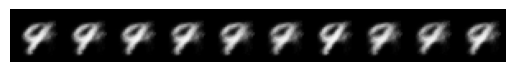

Training:  82%|████████▏ | 9635/11750 [03:53<00:48, 43.53it/s, epoch=42/50, loss=⠀      0.1334, lr=3.81E-04]

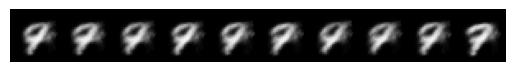

Training:  84%|████████▍ | 9870/11750 [03:59<00:43, 43.32it/s, epoch=43/50, loss=⠀      0.1309, lr=3.73E-04]

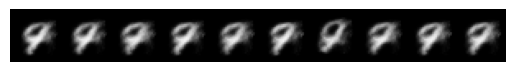

Training:  86%|████████▌ | 10105/11750 [04:04<00:38, 42.63it/s, epoch=44/50, loss=⠀      0.0833, lr=3.64E-04]

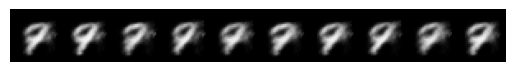

Training:  88%|████████▊ | 10340/11750 [04:10<00:33, 41.93it/s, epoch=45/50, loss=⠀      0.0819, lr=3.56E-04]

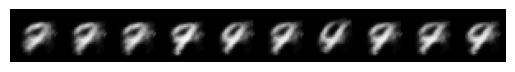

Training:  90%|█████████ | 10575/11750 [04:16<00:26, 44.19it/s, epoch=46/50, loss=⠀      0.1332, lr=3.47E-04]

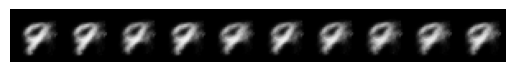

Training:  92%|█████████▏| 10810/11750 [04:21<00:20, 45.00it/s, epoch=47/50, loss=⠀      0.0994, lr=3.39E-04]

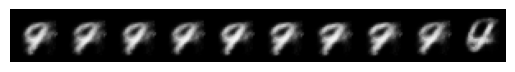

Training:  94%|█████████▍| 11045/11750 [04:27<00:16, 44.05it/s, epoch=48/50, loss=⠀      0.1063, lr=3.31E-04]

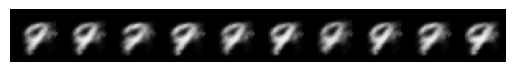

Training:  96%|█████████▌| 11281/11750 [04:33<00:10, 43.79it/s, epoch=49/50, loss=⠀      0.1163, lr=3.24E-04]

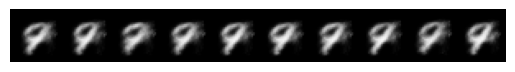

Training:  98%|█████████▊| 11517/11750 [04:38<00:05, 43.55it/s, epoch=50/50, loss=⠀      0.1243, lr=3.16E-04]

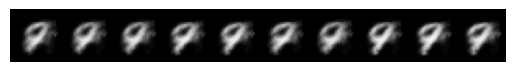

Training: 100%|██████████| 11750/11750 [04:44<00:00, 41.30it/s, epoch=50/50, loss=⠀      0.1241, lr=3.09E-04]



In [12]:
def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 100
learning_rate = 1e-3
epochs = 50
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

# Construct Score Network (MLP)
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
score_model = ScoreNet().to(device)
vae_network = torch.load("vae_mnist_model.pth", weights_only=False).to(device)

# Construct model
model = VAE_DDPM(vae_network, score_model, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        # Sample from latent space (dim=6)
        samples = model.sample((nsamples, 6)).cpu()
        
        # VAE output is sigmoid 0..1, no need to remap
        # samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    

# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

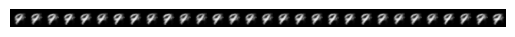

In [13]:
# Sample final model
model.eval()
with torch.no_grad():
    # Sample uniformly from latent space
    nsamples = 30
    samples = model.sample((nsamples, 6)).cpu()
    samples = samples.clamp(0.0, 1.0)

    grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
    plt.gca().set_axis_off()
    plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
    plt.show()